# Summary of the data used and analysis performed

### Cuts applied by Valerio's script to all samples:
* $eFlag==0\quad\&\quad eBfcArea>10\quad\&\quad eGoodZone==true$

### Output of Valerio's script:
* $eHeaderID$
* $eViewID$
* $eGrainID$
* $8\times eBfcPolID$ (id of BFCL for each pol)
    * for empty pol -1
* $eIsolated$
    * single grains are $eIsolated<0 \rightarrow$ no n-peaks events and no microtracks 
* $eSetNCopy$ (number of non-empty pols)

## Number of raw events obtained from ROOT files using IDs from above

Periodic boundary conditions: during loading 9th polarisation is added as a copy of 1st.

* These datasets contain not only isolated grains. Isolated grains are picked on the later stage.

In [13]:
import h5py
N = {}
with h5py.File('data/data_raw_9pol.h5', 'r') as dfile:
    for cl in dfile.keys():
        if cl=='fog': N[cl] = 0
        for k in dfile[cl].keys():
            if cl=='fog': N['fog'] += dfile[cl+'/'+k+'/features'].shape[0]
            elif k=='60keV' or k=='30keV': N[cl+'/'+k] = dfile[cl+'/'+k+'/features'].shape[0]
            else:
                N[cl+'/'+k] = 0
                for sc in dfile[cl+'/'+k].keys():
                    N[cl+'/'+k] += dfile[cl+'/'+k+'/'+sc+'/features'].shape[0]
for k in N.keys():
    if k=='fog': print(k+'\t ','\t',N[k],'events'); continue
    print(k, '\t', N[k], 'events')

Carbon/100keV 	 203845 events
Carbon/30keV 	 182179 events
Carbon/60keV 	 189537 events
fog	  	 379705 events
gamma/Co60 	 178386 events
gamma/Cs137 	 177102 events


#### Further cleaning rejected not isolated grains, divergent samples ($lx$ and $vol$) and images on the edge of emulsion (part of the image is zero)
#### For background samples additional cuts were applied to discard the surfaces with silver nanoparticles:
* accepted Z range for `Fog` scans:
    * Scan2: $(-18,24)$
    * Scan3: $(-19,17)$
    * Scan4: $(-24,23)$
    * Scan6: $(-20,23)$
    * Scan7: $(-22,22)$
    * Scan8: $(-21,22)$
    * Scan9: $(-22,21)$
    * Scan11: $(-21,22)$
* acceptance conditions for `Gamma`:
    * $eViewID > 10$
    * Z range: $(-15,10)$

## Number of clean events

In [25]:
import h5py
N_cl = {}
with h5py.File('data/dataset_phys_clean_9pol.h5', 'r') as dfile:
    for cl in dfile.keys():
        if cl=='fog':
            N_cl['fog'] = {}
            for tr_v in ['train','val']:
                tr_v_='test' if tr_v=='val' else tr_v
                N_cl['fog'][tr_v_] = dfile[cl+'/features/'+tr_v].shape[0]
            continue
        for k in dfile[cl].keys():
            N_cl[cl+'/'+k] = {}
            for tr_v in ['train','val']:
                tr_v_='test' if tr_v=='val' else tr_v
                N_cl[cl+'/'+k][tr_v_] = dfile[cl+'/'+k+'/features/'+tr_v].shape[0]

for k in N_cl.keys():
    if k=='fog': print(k+'\t ',end='\t')
    else: print(k, end='\t')
    for tr_v in ['train','test']:
        print(tr_v,' ',N_cl[k][tr_v],'events',end='\t\t')
    print('')

Carbon/100keV	train   108604 events		test   72404 events		
Carbon/30keV	train   101536 events		test   67692 events		
Carbon/60keV	train   104121 events		test   69414 events		
fog	 	train   56971 events		test   37981 events		
gamma/Co60	train   69870 events		test   46580 events		
gamma/Cs137	train   58900 events		test   39268 events		


# Details of the Networks

* Networks are trained signal-background pairwise (9 pairs)
* For each sign-bckg pair 2 networks are trained: with rotations during training $(\times 2 \text{ train size})$ and without any rotations
* 18 Networks in total

### Network architecture

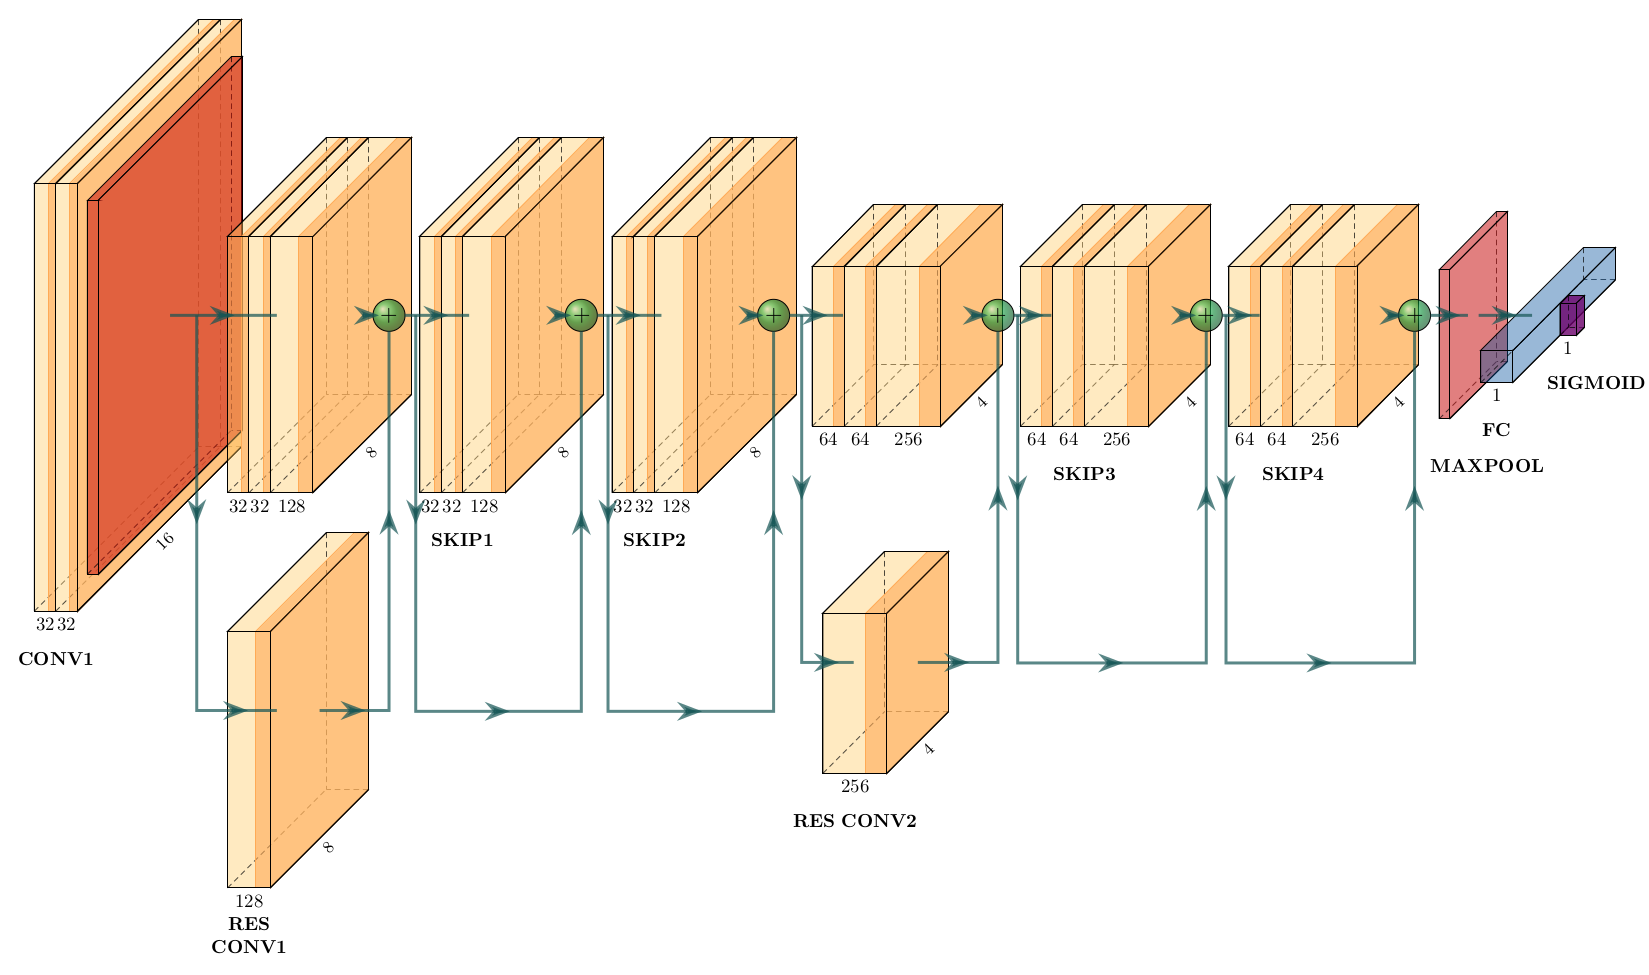

In [31]:
from IPython.display import Image
Image('cnn_res.png')

### Dropout layers:
* 0.4 after ResConv1
* 0.7 after Skip2
* 0.4 after ResConv2
* 0.7 after Skip4

### Activation functions (non-linearities):
* SWISH
* sigmoid for probabilistis output

### Loss function:
* Binary cross-entropy
    * $-y\log(\hat{y})-(1-y)\log(1-\hat{y})$

### Loss optimizer:
* Nadam (Adam with Nesterov momentum) $\leftarrow$ _fancy gradient descent_
    * $lr = 10^{-4}\quad \beta_1 = 0.95\quad \beta_2 = 0.999$

Total number of trainable model parameters: 598 765

## Details of the training
* Each model is trained for 50 epochs (gradient descent cycles on the whole training data)
* Gradient steps are batches of 256 samples
* For _rotational_ model each batch is rotated on a random angle

## Model output: Probability of being signal
* To get binary output a threshold on the probability has to be imposed